In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from models import VAE
from utils import generate_ring, generate_linear

In [2]:
def compute_loss(model, x):
    z_mean, z_logvar, x_f = model.sampling(x)
    kl_divergance = 0.5*tf.reduce_sum(tf.square(z_mean)+tf.square(z_logvar)-tf.math.log(1e-8+tf.square(z_logvar))-1, 1)
    marginal_likelihood = tf.reduce_sum(x*tf.math.log(x_f)+(1-x)*tf.math.log(1-x_f), 1)
    kl_divergance = tf.reduce_mean(kl_divergance)
    marginal_likelihood = tf.reduce_mean(marginal_likelihood)
    ELBO = marginal_likelihood - kl_divergance
    loss = -ELBO

    return loss, kl_divergance, marginal_likelihood

@tf.function
def train_step(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss, _, _ = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [3]:
def show_results_with_dataset(model, epoch, dataset):
    _, _, x_f = model.sampling(dataset)

    plt.figure(2)
    plt.scatter(dataset[:,0], dataset[:,1], alpha=.5, color='cornflowerblue', label='real')
    plt.scatter(x_f[:, 0], x_f[:,1], alpha=.5, color='maroon', label='fake')
    plt.xlim(xmin=-0.2, xmax=1.2)
    plt.ylim(ymin=-0.2, ymax=1.2)
    plt.legend(loc='upper left')
    plt.text(0.9, 1.1, 'Epoch(s):'+str(epoch))
    plt.savefig('./results/vae/ring/{:04d}.png'.format(epoch))
    plt.cla()

In [4]:
dataset_size = 5000
train_set_size, test_set_size = 4500, 150
batch_size = 32

# Sampling Linear Dataset
# dataset = generate_linear(dataset_size)

# Sampling Ring Dataset
dataset = generate_ring(dataset_size)

# Scaling Dataset
scaler = preprocessing.MinMaxScaler()
scaled_dataset = scaler.fit_transform(dataset)

train_x, test_x = scaled_dataset[:train_set_size], scaled_dataset[train_set_size:]
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(train_set_size).batch(batch_size)
train_dataset = tf.data.Dataset.from_tensor_slices(test_x).shuffle(test_set_size).batch(test_set_size)

for test_batch in train_dataset.take(1):
    test_sample = test_batch[:test_set_size]

In [5]:
# Make Model
z_dims = 10
model = VAE(z_dims=z_dims)
optimizer = tf.keras.optimizers.Adam(1e-5)

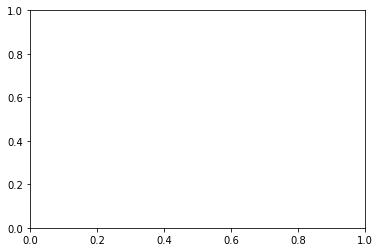

In [6]:
epochs = 1000
for epoch in range(1, epochs):
    for train_data in train_dataset:
        train_step(model, train_data, optimizer)
    # print(epoch)
    show_results_with_dataset(model, epoch, test_sample)